# Section 1: Performance metrics

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rcParams['figure.figsize'] = [10, 10]

Let's load the MNIST dataset. This is a dataset of handwritten numbers. You will encounter it in a lot of machine learning tutorials.

In [2]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

The shape is (60000, 28,28) for the trainset. This means: we have 60000 cases, and every case is a 28x28 matrix. We can visualize a single instance

2

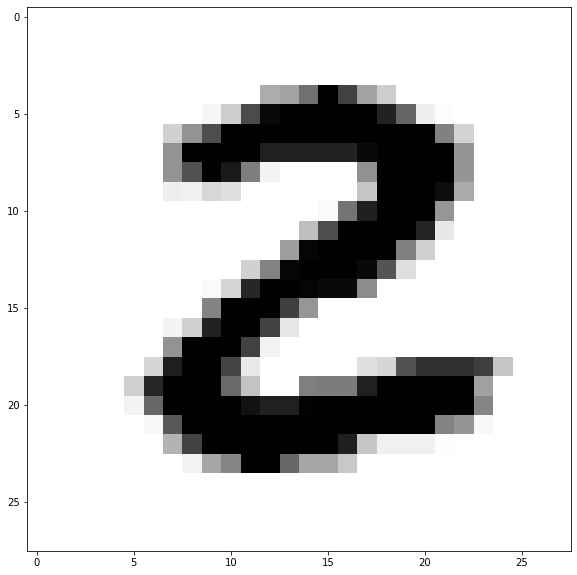

In [3]:
idx = 25 #let's have a look at case 25. You can change this to have a look at others
digit = X_train[idx]
plt.imshow(digit, cmap='binary')
y_train[idx]

Let's start with trying to predict the cases with number 3 only.

In [4]:
y_train_single, y_test_single = (y_train == 3, y_test == 3)

np.mean(y_train_single) , np.mean(y_test_single)

(0.10218333333333333, 0.101)

Let's check how balanced the dataset is

<AxesSubplot:xlabel='train'>

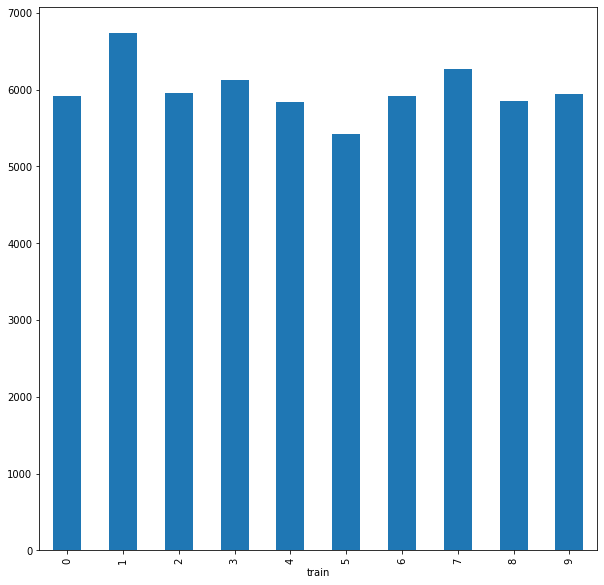

In [5]:
pd.DataFrame(y_train, columns = ['train']).\
    groupby('train').\
    size().\
    plot.bar()

We can see that about 10% of the dataset is a three. This is what you would expect for an evenly distributed set, which the barplot confirms. Now lets reshape the 28x28 matrices to a vector of 28x28=784 numbers.

In [6]:
# the -1 tells reshape: reshape to a matrix where the amount that should be at -1 is deducted from the other amounts.
# because the first number is 60.000, reshape will make sure the second value is 784, because that is the only way
# to make a matrix with 60.000 rows, in this case.
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape

(60000, 784)

What we are actually doing, is reshaping the grid into one long vector. While that might be a weird representation for an image, a classifier works suprisingly well.

Can you understand, what the classifier is doing with this representation? Could you explain in normal language what the strategy of this approach is? The logic of why this works? What would be a downside of this approach?

Now, let's fit a stochastic gradient classifier.

In [7]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(random_state=5, max_iter=10, n_jobs=4)
sgd.fit(X_train, y_train_single)

SGDClassifier(max_iter=10, n_jobs=4, random_state=5)

Let's visualize what the model is doing, in terms of weight. Can you explain what the model is doing, and why?

<AxesSubplot:>

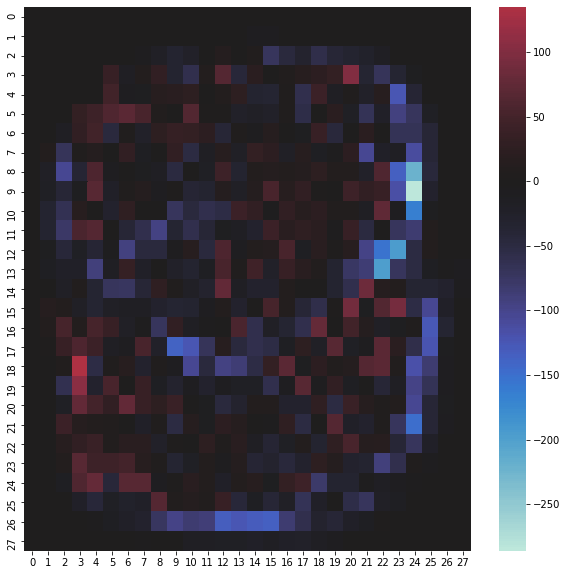

In [8]:
weights = sgd.coef_.reshape(28, 28)
sns.heatmap(weights, center = 0)

How did we do?

In [9]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd, X_train, y_train_single, cv = 3, scoring='accuracy')

array([0.96585, 0.95275, 0.95815])

That looks great. But don't cheer to fast... This high percentage is due to the unbalanced dataset. 
Let's see how a dummy classifier performs, that just picks the most frequent occurence (in our case: 90% is NOT a three, so the dummy will predict that everything is NOT a three.)

In [10]:
from sklearn.dummy import DummyClassifier 
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train_single)
cross_val_score(dummy_majority, X_train, y_train_single, cv = 3, scoring='accuracy')

array([0.89785, 0.8978 , 0.8978 ])

Ai... That are pretty high scores too. Maybe we didn't do as well as simply looking at the accuracy seemed to promise. 

This should be a lesson about the problems you could encounter when trying to assess performance on an unbalanced dataset.

In [11]:
# usefull for plotting heatmaps of a confusion matrix
def cfm_heatmap(cfm, figsize = (8,8), scale = None, vmin=None, vmax=None):
    """
    figsize: tuple, default (8,8)
    scale: string. The direction over which the numbers are scaled. Either None, 'total', 'rowwise' or 'colwise'
    """
    
    if (scale == 'total'):
        cfm_norm = cfm / np.sum(cfm)
    elif (scale == 'rowwise'):
        cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
    elif (scale == 'colwise'):
        cfm_norm = cfm / np.sum(cfm, axis=0, keepdims=True)
    else:
        cfm_norm = cfm
    plt.figure(figsize=figsize)
    plot = sns.heatmap(cfm_norm, annot = cfm_norm, vmin=vmin, vmax=vmax)
    plot.set(xlabel = 'Predicted', ylabel = 'Target')


We are going to make a confusion matrix. Now it is much clearer what is going on.

0.0

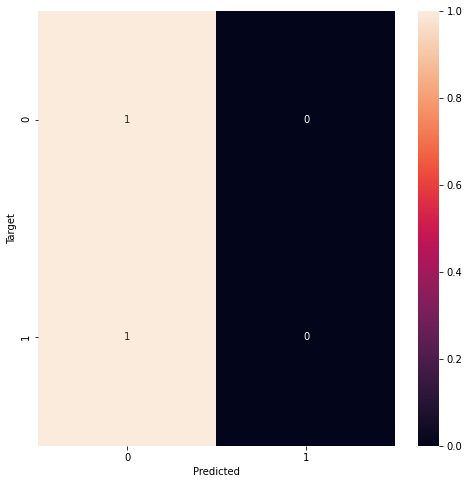

In [12]:
from sklearn.metrics import confusion_matrix, f1_score
yhat_dummy = dummy_majority.predict(X_test)


cfm = confusion_matrix(y_test_single, yhat_dummy)
cfm_heatmap(cfm, scale = 'rowwise')

f1_score(y_test_single, yhat_dummy)

So, what is going on? Well, we see that in the column predicted, everything is predicted as a 0. So this means that of the targets with label 0 (not three), we predicted 90% accurate as a 0. But for target 1 (in our case, the number three), we also predicted everything as 'not three'. A nice way to express this is with the f1-score.

**Precision**: how many of the samples *predicted* as positive are actually positive

$$ Precision = \frac{TP}{TP + FP}$$

**Recall**: how many of *actual* positive samples are indeed predicted as positive

$$ Recall = \frac{TP}{TP + FN}$$

**F-score**: the harmonic mean of precision and recall

$$ F = 2 * \frac{precision * recall}{precision + recall} $$

If we look at the f1-score, it is actually zero. So, let's make a confusion matrix of the SGD classifier:

0.8256513026052105

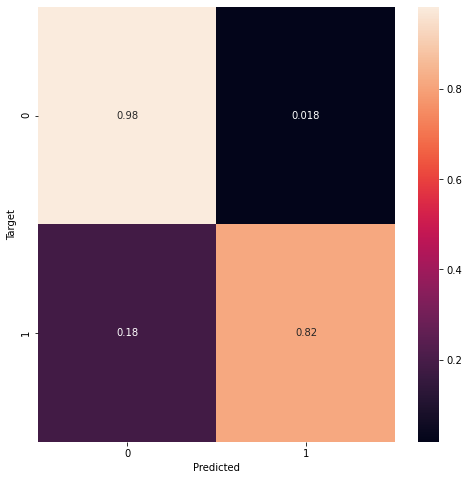

In [13]:
y_test_hat = sgd.predict(X_test)

cfm = confusion_matrix(y_test_single, y_test_hat)
cfm_heatmap(cfm, scale = 'rowwise')

f1_score(y_test_single, y_test_hat)

This looks much better. This should also make clear, how you can be deceived with a simple accuracy measure, but you can see a difference in performance if you look at the confusion matrix.

 We normalized rowwise, wich means that the rows (the actual label) sum up to 1. We see that we predicted 82 percent of the actual threes indeed as a three, making an error in 18% of the cases. We also mistook 1.8% of the non-threes for a three. So let's look at what's going on internally:

In [14]:
from sklearn.model_selection import cross_val_predict

y_decision = cross_val_predict(sgd, X_train, y_train_single, cv = 3, n_jobs = 4, method = 'decision_function')

Let's have a look at the first few values.

In [15]:
val = zip(y_decision[5:10], y_train_single[5:10])
pd.DataFrame(val)

,0,1
0,-316072.225685,False
1,-97063.724417,False
2,161748.616761,True
3,-94219.428047,False
4,-251240.692439,False


You can probably figure out what is going on. Low values mean 'not a three', high values mean 'a three'. By using these decision values, we can change the behavior of the classifier to be more strict, or more loose when it comes deciding if something is a three, or not.

In [16]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_train_single, y_decision)


In [17]:
data = pd.DataFrame({'precision':precision[:-1],'recall': recall[:-1], 'thresholds':thresholds})

<AxesSubplot:xlabel='thresholds', ylabel='precision'>

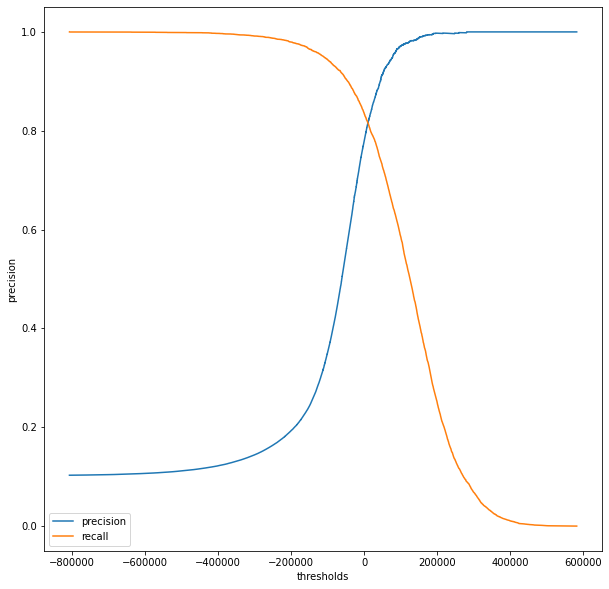

In [18]:
sns.lineplot(x = 'thresholds', y='precision', label = 'precision', data = data)
sns.lineplot(x = 'thresholds', y='recall', label = 'recall', data=data)

As you might have figured out by now, this plot shows that you can achieve any precision you want! The only problem is that your recall will drop, and vice versa... In some cases you could want to tune this threshold.

In [19]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_single, y_decision)
data = pd.DataFrame({'fpr' : fpr, 'tpr':tpr})

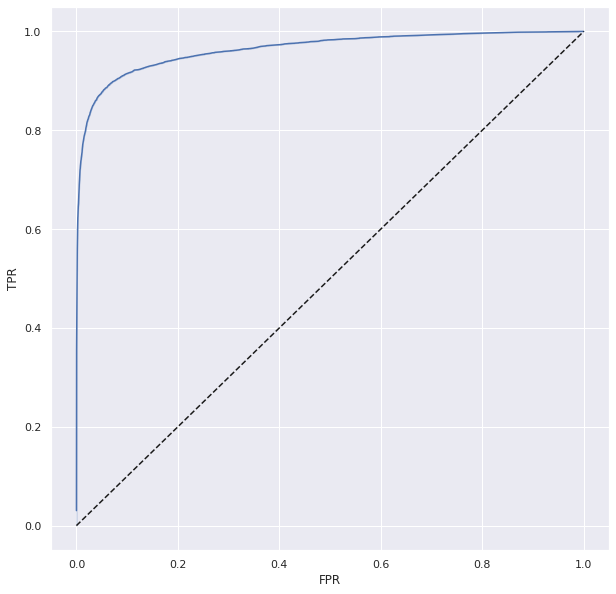

In [20]:
sns.set_theme()
plot = sns.lineplot(x = 'fpr', y = 'tpr', data=data)
plot.set(xlabel = 'FPR', ylabel = 'TPR')
plt.plot([0,1], [0,1], 'k--')

Another visualization that is often used, is a ROC-curve. You plot the False Positive Rate against the True Positive Rate. The diagonal line is what you expect from coincence, so you should get away from that.

The steep rise means: even though the False Positive Rate is very low, you identify already about 60-80% of the True Positive cases. That is nice!

If you also want to get those last difficult cases, you will have to accept that your False Positive rate will also grow, meaning that you will make more mistakes in giving something a label while you should not have done so.

##  Multiclass
Now let's move on to a more complex case, where we actually want to predict every number.

In [21]:
# first scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_train)

In [22]:
# then fit a SGD classifier
sgd = SGDClassifier(random_state=5, max_iter=50, n_jobs=4)
yhat = cross_val_predict(sgd, X_scale, y_train, cv = 3)

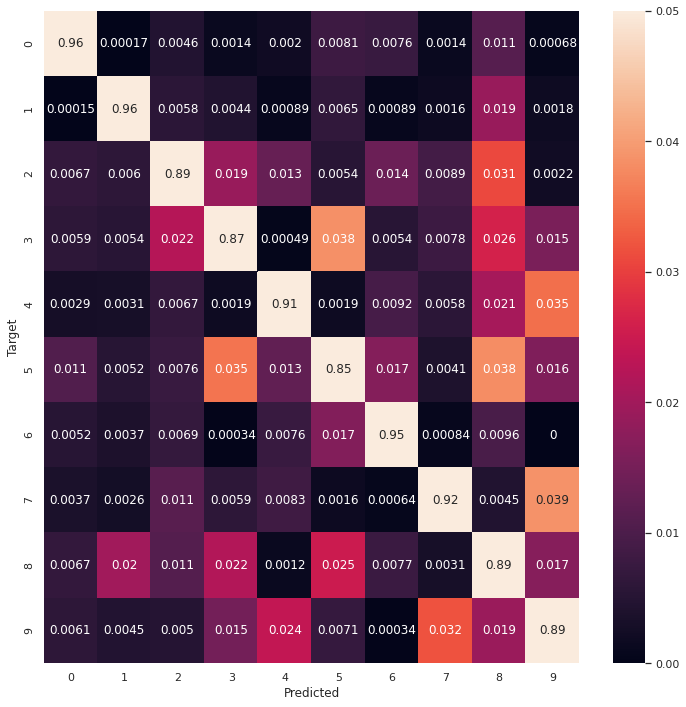

In [23]:
cfm = confusion_matrix(y_train, yhat)
cfm_heatmap(cfm, figsize=(12,12), scale='rowwise', vmax= 0.05)

This might seem like a lot of information to take in. But, on the other hand, let's not forget that we have 10 cases to predict. This means that we have 10 cases, and every case might get one out of 10 labels. This gives us 100 cases in total. Considering that, the heatmap is a nice way to quickly spot the problems.

Again, we normalised over the rows. We see that what is actually a three is often mistaken for a five. The same goes the other way around. Also the seven is often mistaken for a nine.

# Section 2: Regularization

## 2.1 non linear data
Let's generate some synthetic data get get a grip on linear models and regularization.

In [24]:
def generate_linear_data(n, k, noise_range = 1):
    """
    This generates data for n cases and  k features
    Returns a tuple of X, y and weights.
    """
    bias = np.random.randint(low=1, high=5, size=(1,k))
    data = np.random.rand(n, k) + bias

    # we specify weights for every feature
    W = np.random.randint(low=5, high=25, size=(k,1))
    # add some uniform noise
    noise = np.random.uniform(low = -noise_range, high=noise_range, size=(n, 1))
    # and multiply every feature with a weight
    y = np.dot(data, W) + noise

    return (data, y, W)

In [25]:
# we make n observations, with some features
np.random.seed(42)
n = 100 # we start with just 100 observations
k = 1 # and one feature
X, y, W = generate_linear_data(n, k)
W

array([[11]])

After having created some simple dataset with a linear relation in it, let's fit a model.

In [26]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X, y)

# make evenly spaced values over the input range
newx = np.linspace(min(X), max(X), 100)
# and predict with those
yhat = linreg.predict(newx)


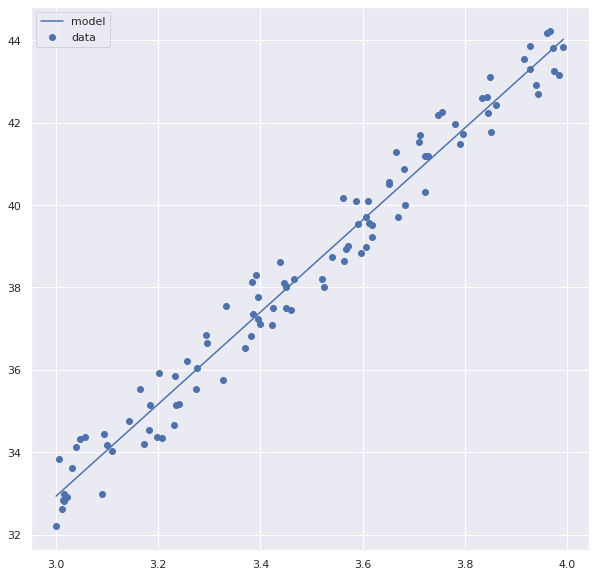

In [27]:
# now let's compare the data and the model
plt.scatter(X, y, label = 'data')
plt.plot(newx, yhat, label = 'model')
plt.legend()

In [28]:
linreg.coef_, W

(array([[11.18443895]]), array([[11]]))

We can see that we found a nice model. The actual weight was 11, and we found around 11.2, which is nice considering the noise and just 100 observations. Because the data has just one feature, we can easily visualize the trainset and the prediction.

Let's see how this scales.

In [29]:
np.random.seed(42)
n = 100 
k = 15 # increase this to 15 features
X, y, W = generate_linear_data(n, k, noise_range=5) # and increase the noise

linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression()

The nice thing of a synthetic dataset is that we know what the weights are. We can see how close we get. The differences are due to the noise. While we can see some errors growing, this is still pretty good, considering the increased noise and the small amount of data.

<AxesSubplot:xlabel='index', ylabel='value'>

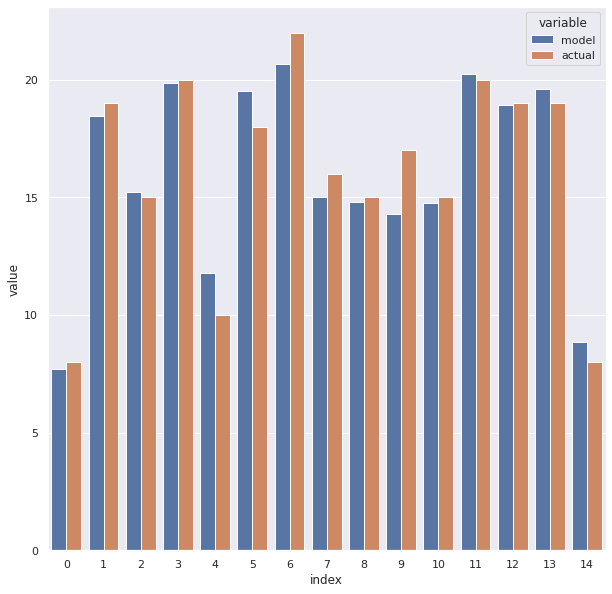

In [30]:
weights = pd.DataFrame(zip(linreg.coef_.T.flatten(), W.flatten()), columns=['model', 'actual'])
data = weights.reset_index().melt(id_vars='index')
sns.barplot(data = data, x = 'index', y = 'value', hue = 'variable')

We can't visualize 10 features easily. But we can simply plot the outcomes. If we plot the prediction on one axis, and the actual value on the other axis, we expect a diagonal line. 

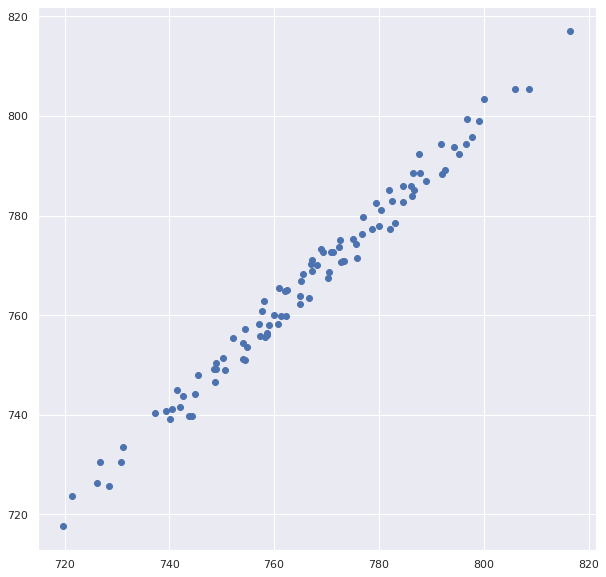

In [31]:
yhat = linreg.predict(X)
plt.scatter(y, yhat)

This is very close to a diagonal line. Even though we missed some weights, we still did a good job. But what if we make the relationship non-linear?

In [32]:
# we create 100 observations
n = 100

# this way, our X will go over the range [-3, 3]
X = 6 * np.random.rand(n, 1) - 3
# let's use a quadratic equation
y = 0.5 * X**2 + X + 2 + np.random.rand(n, 1) 

In [33]:
linreg.fit(X, y)

newx = np.linspace(min(X), max(X), 100)
yhat = linreg.predict(newx)

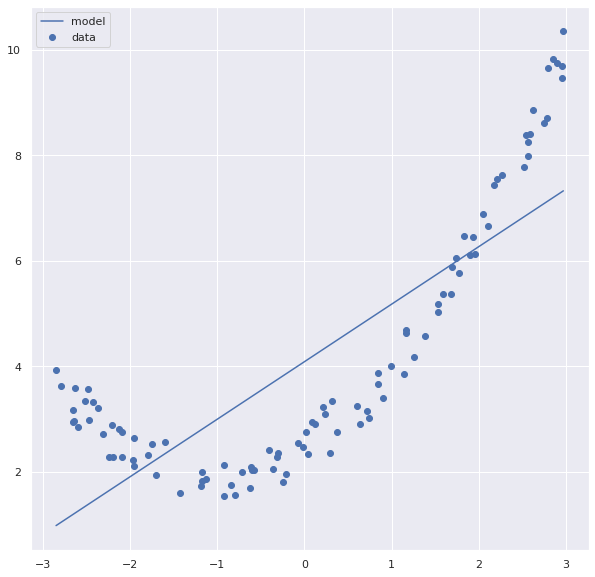

In [34]:
plt.scatter(X, y, label = 'data')
plt.plot(newx, yhat, label = 'model')
plt.legend()

Ai.... We can see that, even though the model isn't that complex, we will `never` fit this with a straight line... 
So we will use a trick. We will distort the features by adding polynomial variations.

# 2.2 Basis expansion

In [35]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree = 3, include_bias=True)
X_poly = poly.fit_transform(X)

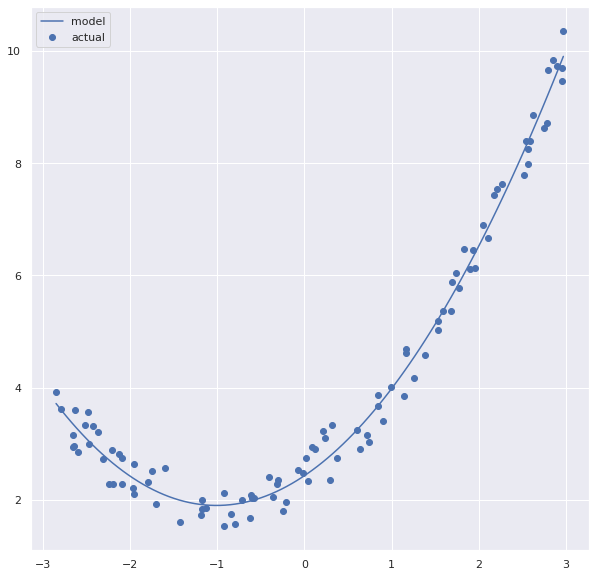

In [36]:
linreg.fit(X_poly, y)

newx = np.linspace(min(X), max(X), 100)
X_new_poly = poly.fit_transform(newx)
yhat = linreg.predict(X_new_poly)

plt.scatter(X, y, label = 'actual')
plt.plot(newx, yhat, label = 'model')
plt.legend()

Ah! much better. But, there is a problem. By just increasing the degree of polynomial features, we will be able to get arbitrarily close to the outcome!

(-3.0, 3.2, 0.0, 10.0)

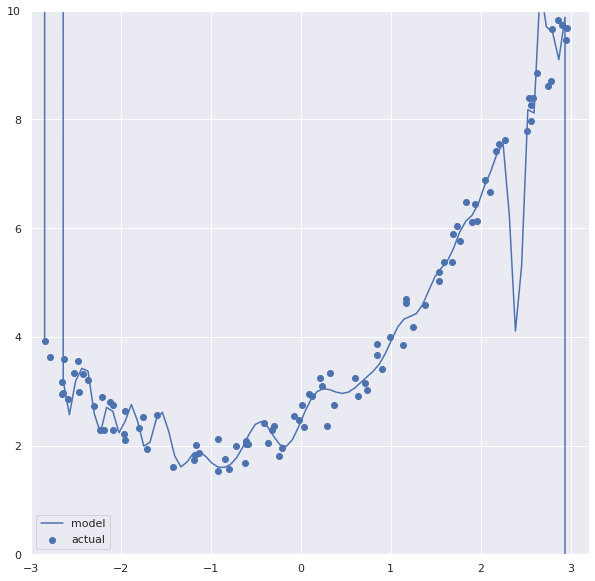

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# set the degree to 100 (change it, to see what happens)
degree = 100

polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
std_scaler = StandardScaler()
lin_reg = LinearRegression()

polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])

polynomial_regression.fit(X, y)

newx = np.linspace(min(X), max(X)+1, 100)
yhat = polynomial_regression.predict(newx)

plt.scatter(X, y, label = 'actual')
plt.plot(newx, yhat, label = 'model')
plt.legend()
plt.axis([-3, 3.2, 0, 10])

This is clearly overfitting... The model is much to complex. While this might perform nice on the trainset, we will do very bad on any testset.

## 2.3 Regularization
Is there a way to regularize this? In principle, yes. We can use a `Ridge` regularization, for example.

(-3.0, 3.0, 0.0, 10.0)

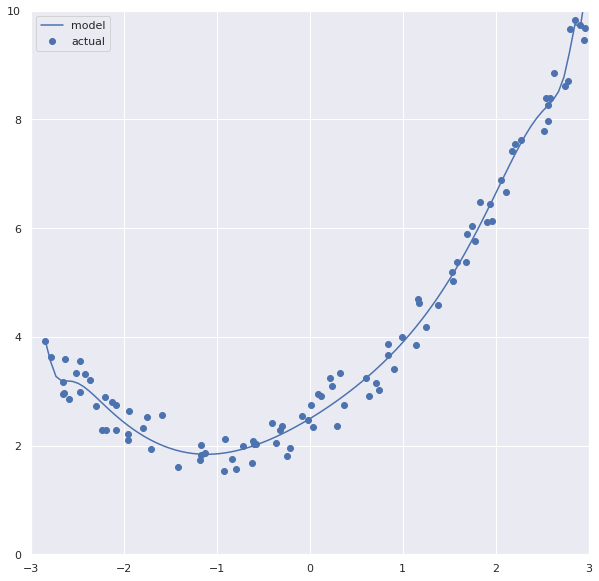

In [38]:
from sklearn.linear_model import Ridge

polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("ridge", Ridge(alpha=0.01)),
        ])

polynomial_regression.fit(X, y)


newx = np.linspace(min(X), max(X), 100)
yhat = polynomial_regression.predict(newx)

plt.scatter(X, y, label = 'actual')
plt.plot(newx, yhat, label = 'model')
plt.legend()
plt.axis([-3, 3, 0, 10])

Now, this is much better. A few things to note:

- we are doing two things that oppose eachother. One the one hand, we make our model way too complex by using a 100-degree polynomial.
- to counteract that complexity, we regularize the model heavily.

At first glace, you might say, don't make your data so complex to add 100 degree polynomials. One response to that could be: well, but this is to make a point, to teach you how regularization works.

But there is something more to it: sometimes, you have really a lot of features. And you really don't know, which features are usefull, and which features are not. In that case, This could be a way to do some feature selection. You see that it can work pretty good.

Another point is: we are using linear models. Often, data is not linearly separable. If we transform the data, that transformed data might suddenly shift to being linearly separable. Because the polynomial features add really a lot of features, and we might need just a few of them, controlling the weights is usually a good idea. As a rule of thumb, however, the simpler your model is, the better. If two models are more or less equal in performance, you should always pick the simpler model. The complexer the model is, the higher the chances are that you will overfit.

So, let's find out. What is a sensible amount of modification of our data? And after we did that, what is a good amount of regularisation? Well, that sounds like a gridsearch question. So let's implement what we learned in the first lesson: we combine a pipe and gridsearch to find out.

In [39]:
from sklearn.model_selection import GridSearchCV

poly_ridge = Pipeline([
            ("poly", PolynomialFeatures()),
            ("scaler", StandardScaler()),
            ("ridge", Ridge()),
        ])


param_grid = {'poly__degree' : [i for i in range(2,20,2)],
    'ridge__alpha': [10**x for x in range(-4,3)]}
gridsearch = GridSearchCV(poly_ridge, param_grid=param_grid, cv=3)
gridsearch.fit(X, y)

gridsearch.best_params_

{'poly__degree': 2, 'ridge__alpha': 0.01}

 But what does this regularisation actually do? Let's find out with the use of the cancer dataset.

In [40]:
from sklearn.model_selection import train_test_split
# we load the data
df = pd.read_csv('~/shared/cancer_data.csv', index_col="id")
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

To make the comparing easier, we create a function that takes a pipe and a list with alpha's as input, fits the pipe for every value of alpha, and plots the weights to compare the impact of different alpha's.

In [41]:
# easy for plotting
def show_impact_of_alpha(alphaList, pipe, X, y):
    steps = [*pipe.named_steps] # this gets the name of the steps
    model = steps[-1] # this takes the last step, which is the model
    for alpha in alphaList:
        fit_params = {model+'__alpha' : alpha} 
        pipe.set_params(**fit_params) # we set one of the alpha's from the alphaList
        pipe.fit(X, y) # and fit the model
        coef = pipe.named_steps[model].coef_.T # get the coeficients from the model
        x = range(len(coef))
        plt.scatter(x, coef, label = alpha) # and plot them
    plt.legend(title = 'alpha')
    plt.title(model)
    plt.xticks(x, X.columns, rotation=90)

Let's do this for l2 (ridge)

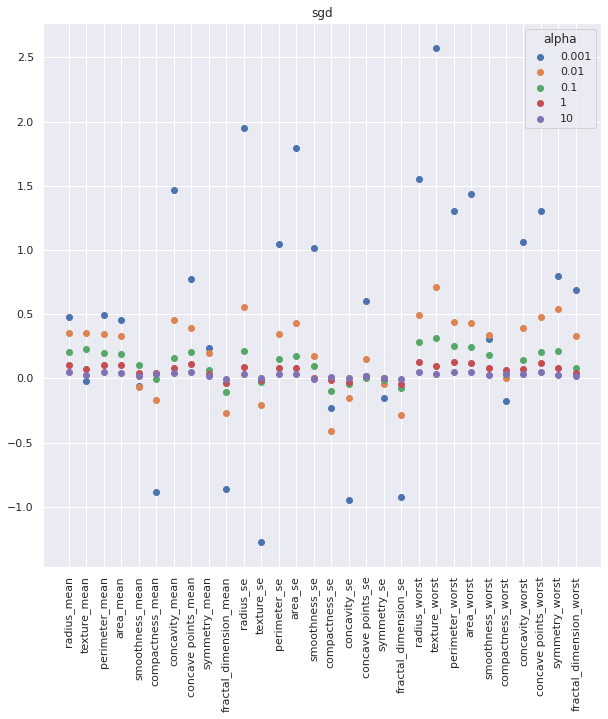

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

# We make a pipe with a scaler and l2 regularization
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('sgd', SGDClassifier(penalty='l2'))
])

alphaList = [10**i for i in range(-3, 2)]
show_impact_of_alpha(alphaList, pipe, X_train, y_train)


And for l1 (lasso)

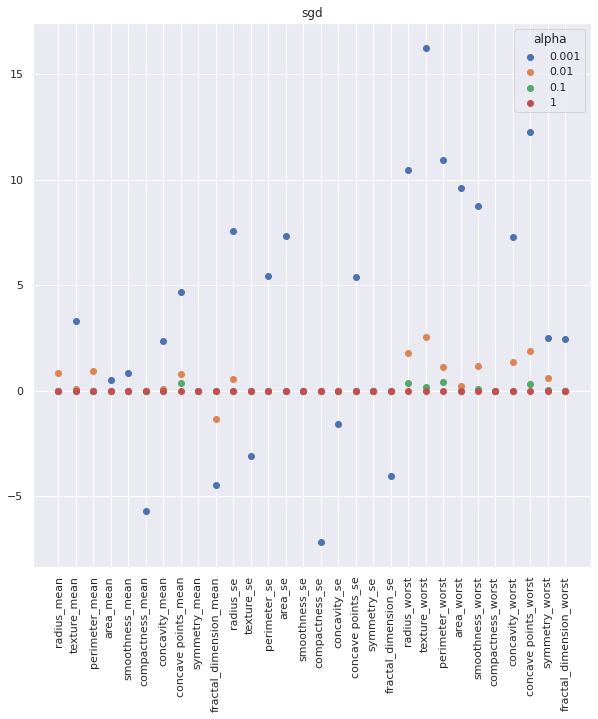

In [43]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
     ('sgd', SGDClassifier(penalty='l1'))
])
alphaList = [10**i for i in range(-3, 1)]
show_impact_of_alpha(alphaList, pipe, X_train, y_train)

What is the difference between the two methods? What can you see happening?

Note that alpha corresponds to $\frac{1}{2C}$ in other linear models such as LogisticRegression that use a $C$ value.

A nice way to find the best model, is to use elasticnet. This combines Ridge and Lasso, and has a `l1_ratio` parameter that sets the amount of mixture between the two regularizations. Luckily, we can find out the best ratio and alpha with `ElasticNetCV` for linear regression, and `penalty='elasticnet` in the SGDClassifier

Note that a good choice of list of values for `l1_ratio` is often to put more values close to 1 (i.e. Lasso) and less close to 0 (i.e. Ridge), as in $[.1, .5, .7, .9, .95, .99, 1]$

In [44]:
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('scaler', StandardScaler()),
     ('sgd', SGDClassifier(penalty='elasticnet'))
])

l1_ratio = [.1, .5, .7, .9, .95, .99, 1]
alphaList = [10**i for i in range(-3, 2)]

param_grid = {'sgd__l1_ratio' : l1_ratio,
                'sgd__alpha' : alphaList} 

gridsearch = GridSearchCV(pipe, param_grid=param_grid, cv=3)
gridsearch.fit(X_train, y_train)

gridsearch.best_params_

{'sgd__alpha': 0.001, 'sgd__l1_ratio': 0.1}

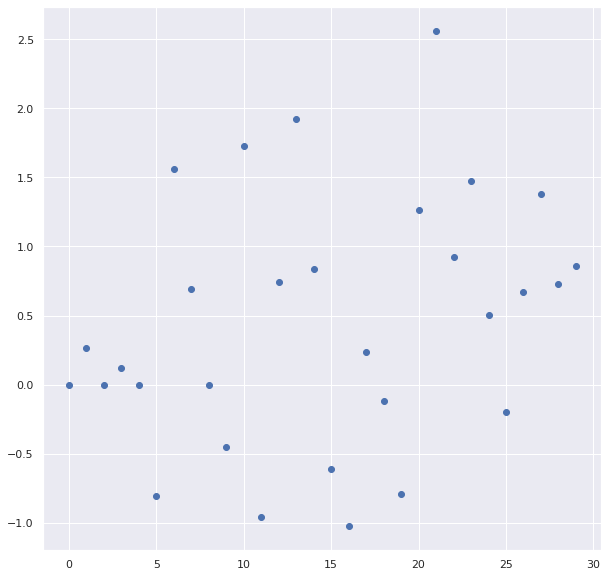

In [45]:
pipe.set_params(**gridsearch.best_params_)
pipe.fit(X_train, y_train)
coefs = pipe.named_steps['sgd'].coef_.flatten()
plt.plot(coefs, 'o')

In [46]:
coefs

array([ 0.        ,  0.26317359,  0.        ,  0.12047147,  0.        ,
       -0.80648045,  1.55755302,  0.69207654,  0.        , -0.45090033,
        1.72930317, -0.95563178,  0.74376486,  1.92208932,  0.83500387,
       -0.60760346, -1.02050674,  0.23738794, -0.11994294, -0.79071982,
        1.26395548,  2.55664569,  0.92331864,  1.47233337,  0.50526551,
       -0.19736605,  0.6694195 ,  1.38084808,  0.72880328,  0.86129413])

In [47]:
# we want the absolute values (the features with the most impact)
absolute_values = np.abs(coefs)
# then find the index of the sorted values
sorted_idx = np.argsort(absolute_values)

# if we want the k highest weights
k = 10
# we select the last k sorted indeces
highest = sorted_idx[-k:]

In [48]:
# these are the k best features, that could be selected to train another (more complex) model
X.columns[highest]

Index(['perimeter_worst', 'texture_se', 'concavity_se', 'radius_worst',
       'concave points_worst', 'area_worst', 'concavity_mean', 'radius_se',
       'area_se', 'texture_worst'],
      dtype='object')

# Section 3: Kernels, basis expansion at scale
A problem with polynomial features is that they don't scale very well. Consider this:

In [49]:
# helper function
from utils import plot_contour, gridsearch_heatmap, compare_results

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
plt.rcParams['figure.figsize'] = [10, 10]

We generate data with 2 features, polynomial degree 2.

In [51]:
X = np.random.rand(100, 2)
print(X.shape)
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X)
X_poly.shape

(100, 2)


(100, 6)

5 features, polynomial degree 5

In [52]:
X = np.random.rand(100, 5)
poly = PolynomialFeatures(5)
X_poly = poly.fit_transform(X)
X_poly.shape

(100, 252)

10 features, polynomial degree 8

In [66]:
X = np.random.rand(100, 10)
poly = PolynomialFeatures(8)
X_poly = poly.fit_transform(X)
X_poly.shape

(100, 43758)

As you can see, this does not scale well. If you set the features to 15 and the poly degree to 15, you will blow up the kernel due to memory shortage....
Conclusion: this grows much too hard to be feasable for sets with more then a handful of features. 

Let's have a look at a way to do basis expansions, without scaling much too hard.

<AxesSubplot:xlabel='x1', ylabel='x2'>

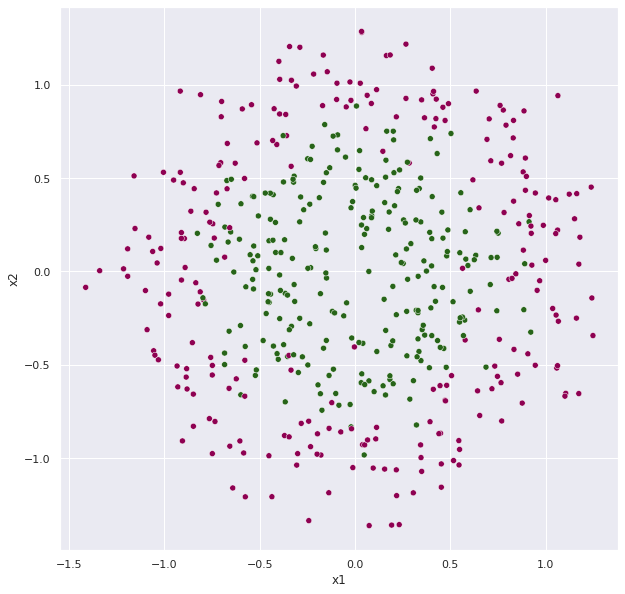

In [67]:
from sklearn.datasets import make_circles
X, y = make_circles(500, noise=0.2, factor=0.5, random_state=5)
data = pd.DataFrame({'x1': X[:,0], 'x2':X[:,1], 'y':y})
cm = plt.cm.PiYG
sns.scatterplot(data = data, x = 'x1', y = 'x2', cmap = cm, c=y)

This obviously won't work with a linear classifier. So we can do basis expansion with a kernel. Due to a neat mathematical trick, we can do basis expansion without actually paying the price in terms of memory and time to calculate hundreds of thousands of features. 

Obviously this wouldn't be a problem with 2D data like in this example, but this will scale regardless of the amount of features.

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)

In [70]:
from sklearn.svm import SVC
pipe = Pipeline(
    [
        ("svm", SVC(kernel='rbf')) #
    ]
)

# param_grid = {'svm__C': np.linspace(1,20, 10),
#               'svm__gamma': np.linspace(0.01, 0.4, 10)}
param_grid = {'svm__C': [10**x for x in range(-4,3)],
              'svm__gamma': [10**x for x in range(-4,3)]}

gridsearch = GridSearchCV(pipe, param_grid=param_grid, cv=3)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'svm__C': 1, 'svm__gamma': 1}

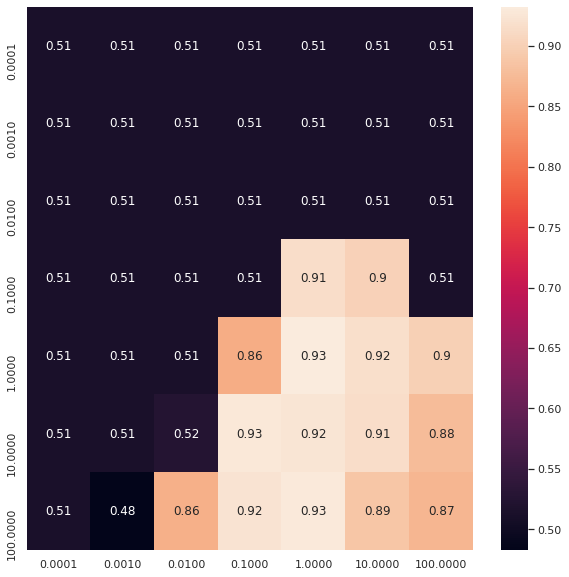

In [71]:
gridsearch_heatmap(gridsearch, param_grid)

Ok, let's fit the pipe, and collect the results with regards to the train and test set. This way we can compare different models quite easy with regards to performance and overfitting.

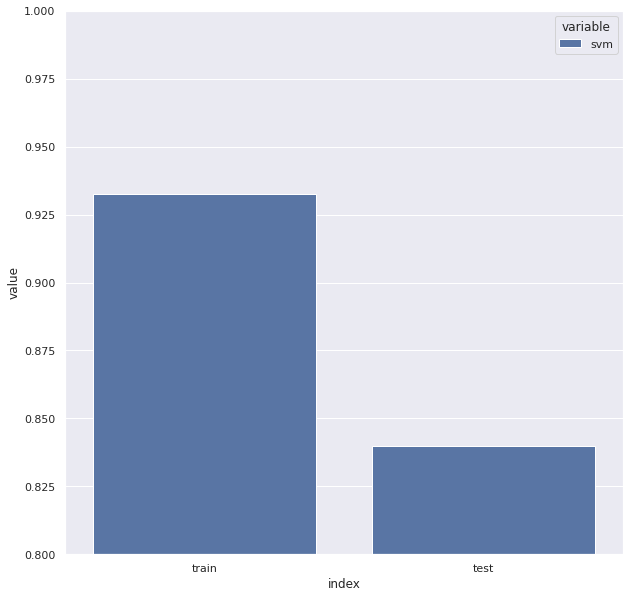

In [72]:
pipe.set_params(**gridsearch.best_params_)
pipe.fit(X_train, y_train)
results = {}
results['svm'] = pipe.score(X_train, y_train), pipe.score(X_test, y_test)
compare_results(results, ylim=0.8)

But now the question, how does the kernel work? We can plot on a grid the outcome. Below you can see the pink area, where every point inside this area will be classified as belonging to the red class. The green area will classifiy every point in that area as belonging to the green class. You can see that, due to some noise, some green point fall inside the pink area, and some red point fall into the green area.

Considering that we generated a circle with some noise, this is actually a nice approximation of the original function without noise.

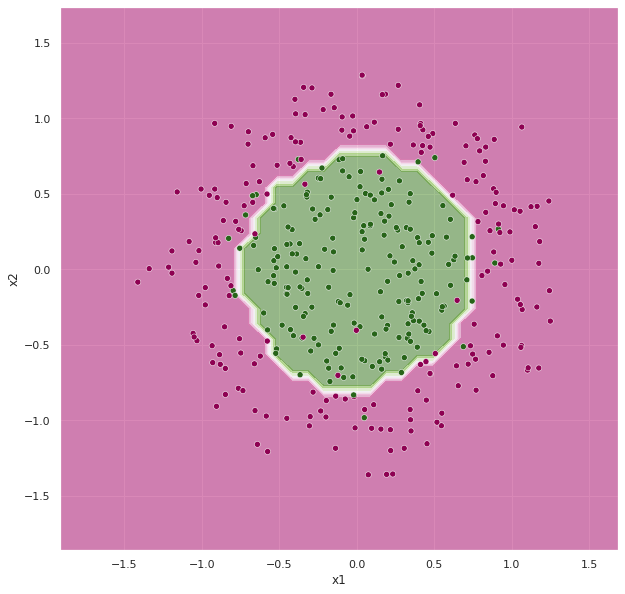

In [73]:
plot_contour(X_train, y_train, pipe)

Let's compare that to a Random Forest.

In [75]:
from sklearn.ensemble import RandomForestClassifier

# we make a pipe
pipe = Pipeline(
    [
        ("rfc", RandomForestClassifier())
    ]
)

# set a grid
param_grid = {'rfc__max_depth': np.arange(2, 50, 2),
              'rfc__n_estimators': np.arange(10, 100, 10)}

gridsearch = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=4)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'rfc__max_depth': 48, 'rfc__n_estimators': 90}

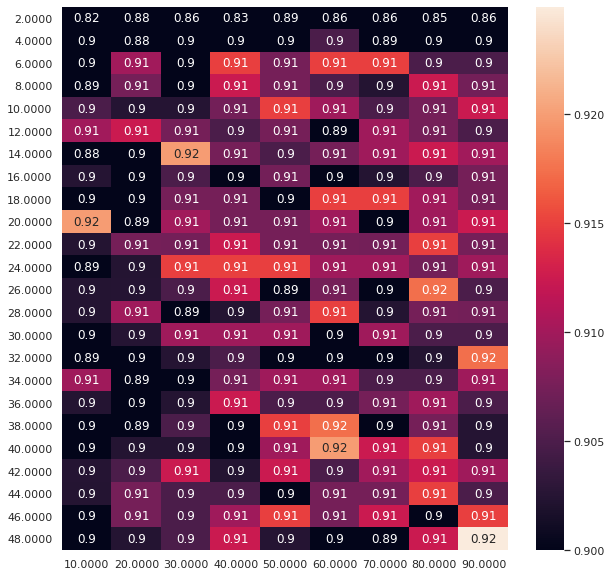

In [76]:
gridsearch_heatmap(gridsearch, param_grid, vmin = 0.9, figsize=(10,10))

The heatmap looks a bit like white noise. Everything seems sort of ok, with values around 0.9. This is typically for random forests. Now let's try to peek inside the model.

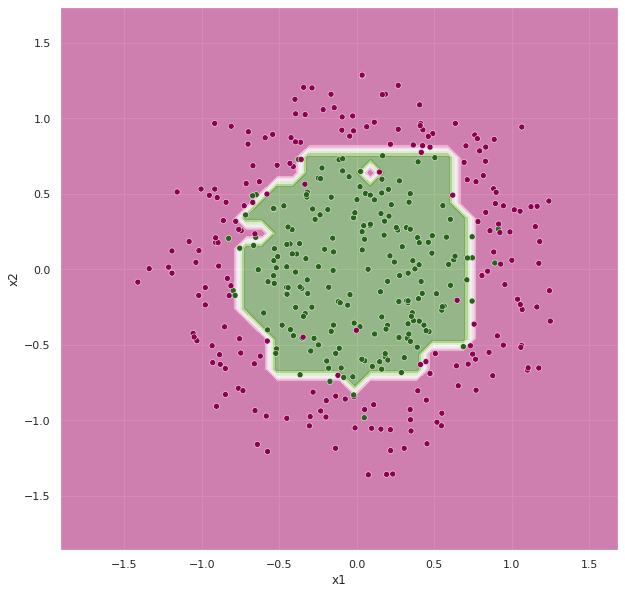

In [77]:
pipe.set_params(**gridsearch.best_params_)
pipe.fit(X_train, y_train)
plot_contour(X_train, y_train, pipe)

Hopefully, you can appreciate the difference between the SVM+kernel and this. The randomforest is overfitting. The green shape is much less like a circle. It's more a square with some rough corners, and even a small red patch inside the green area. Now let's compare this on the train-test set.

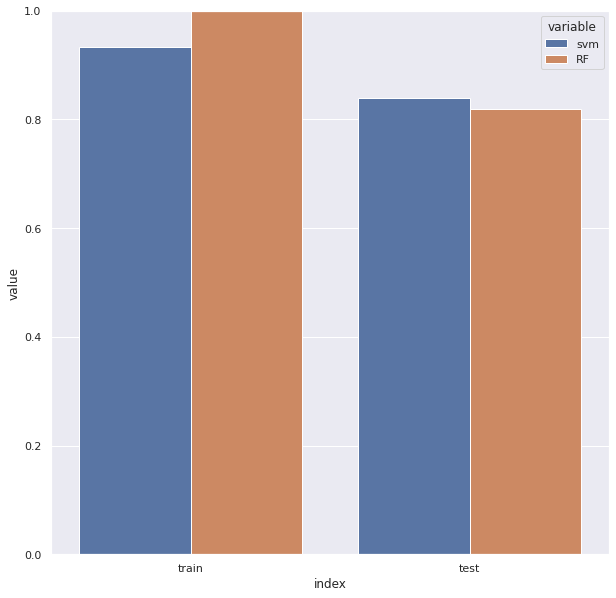

In [80]:
results['RF'] = pipe.score(X_train, y_train), pipe.score(X_test, y_test)
compare_results(results);

The random forest scores much better on the trainset, but much lower on the test set. This is a sign of overfitting; we can conclude that the randomforest is overfitting much worse on than the SVM. Also, looking at the testset, the SVM is expected to perform better. This is not just something you can see on the train-test split, but should also be able to understand based on the contour plot of the model; the SVM is much smoother, the RF is overfitting. This is typical behavior of a Random Forest. This behavior will decrease with more datapoints, where the two models will grow closer to each other. Also, under some circumstances, the Random Forest will outperform the SVM. This depends on parameters like : amount of features, amount of observations, your skills in hyperparameter tuning.